In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
import anndata as ad
from scipy import sparse
from anndata import AnnData
from matplotlib import colors

In [3]:
def get_majority_label(adata, transferred_label, leiden_label):
    return adata.obs[
        [transferred_label, leiden_label]
    ].value_counts().reset_index().sort_values(
        ['count', leiden_label], ascending=False,
    ).drop_duplicates(
        leiden_label,
        keep='first',
    ).set_index(leiden_label)[transferred_label].to_dict()

In [32]:
neighbors_adata = sc.read("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/merged_data/integration/dataset~integration_merged_data/method~scvi/batch~batch,label~harmonized_anno,hyperparams~d453d7a675,lineage_key~None/neighbors.h5ad")


In [43]:
neighbors_adata

AnnData object with n_obs × n_vars = 535908 × 2007
    obs: 'author_annotation', 'manual_celltype_annotation', 'batch', 'condition', 'timepoint', 'dataset', 'fibrotic/control', 'coarse_harmonized_anno', 'Phase', 'SAMP_stage', 'SC_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_group', 'harmonized_anno', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset', 'dataset_colors', 'hvg', 'integration', 'manual_celltype_annotation_colors', 'methods', 'neighbors', 'pca', 'umap'
    varm: 'PCs'
    obsp: 'connectivities', 'connectivities_embed', 'distances', 'distanc

In [42]:
adata_integrated

AnnData object with n_obs × n_vars = 535908 × 2007
    obs: 'author_annotation', 'manual_celltype_annotation', 'batch', 'condition', 'timepoint', 'dataset', 'fibrotic/control', 'coarse_harmonized_anno', 'Phase', 'SAMP_stage', 'SC_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_group', 'harmonized_anno', '_scvi_batch', '_scvi_labels', 'leiden_res1', 'majority_anno'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset', 'dataset_colors', 'hvg', 'integration', 'manual_celltype_annotation_colors', 'methods', 'neighbors', 'pca', 'umap', 'leiden', 'leiden_res1_colors', 'harmonized_anno_colors'

In [4]:
adata_integrated = sc.read("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/merged_data/integration/dataset~integration_merged_data/method~scvi/batch~batch,label~harmonized_anno,hyperparams~d453d7a675,lineage_key~None/adata.h5ad")

In [44]:
adata_integrated.obsp["connectivities"] = neighbors_adata.obsp["connectivities_embed"]

In [46]:
adata_integrated.obsp["distances"] = neighbors_adata.obsp["distances_embed"]  

integrated anndatas have a different index as unintegrated --> use integrated anndata (with layers in right order) for final annotation

In [11]:
scvi_umap_coord = np.load("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/merged_data/integration/dataset~integration_merged_data/method~scvi/batch~batch,label~harmonized_anno,hyperparams~d453d7a675,lineage_key~None/umap_coordinates.npy")
adata_integrated.obsm["X_umap"] = scvi_umap_coord
#adata_integrated.obsm["X_umap"] = adata_integrated.obsm["X_emb"]

In [47]:
# leiden 
sc.tl.leiden(adata_integrated, key_added="leiden_res1", resolution=1.0)

... storing 'majority_anno' as categorical


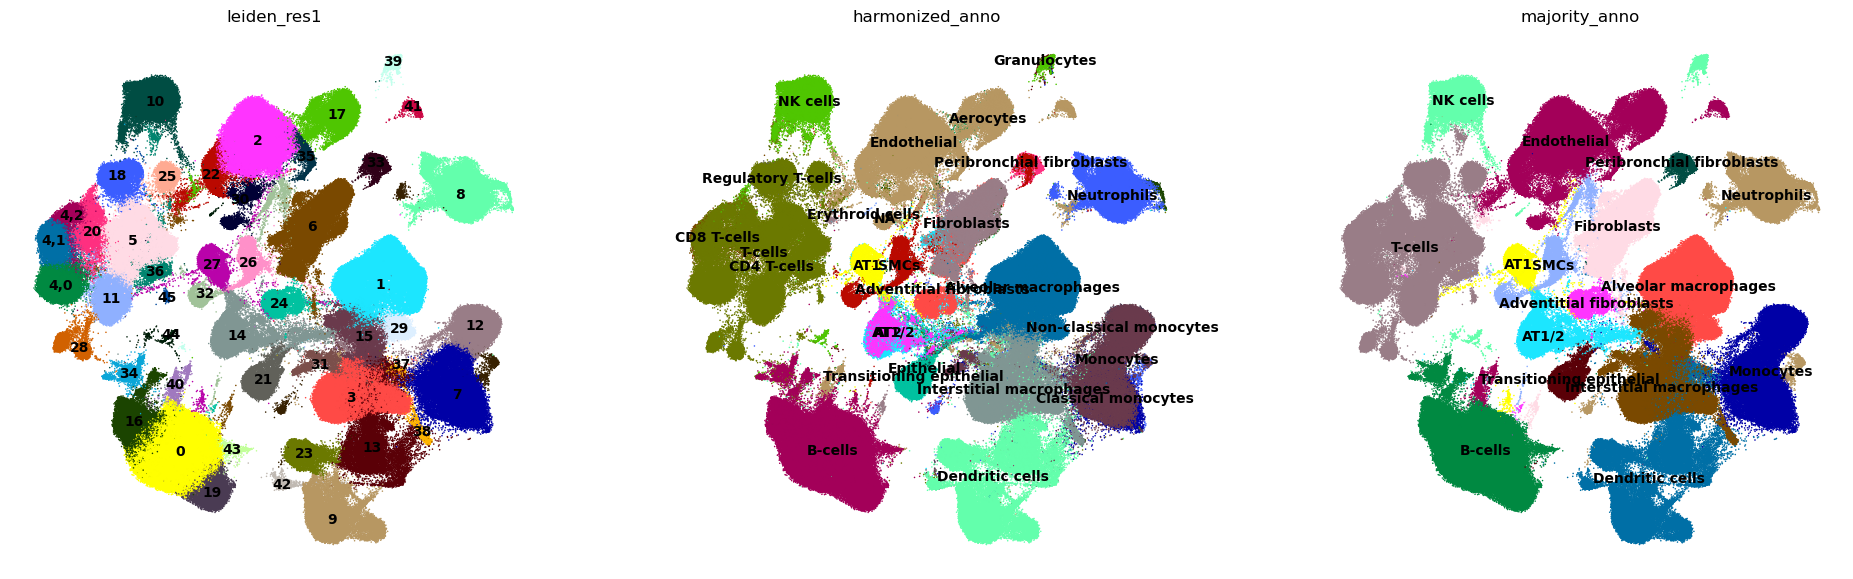

In [54]:
plt.rcParams['figure.figsize'] = (7, 7)
sc.pl.umap(
    adata_integrated,
    color=["leiden_res1", "harmonized_anno", "majority_anno"],
    legend_loc="on data", 
     size=5, palette=sc.pl.palettes.default_102, frameon=False
)

In [49]:
sc.tl.leiden(adata_integrated, restrict_to= ("leiden_res1", ['4']),  key_added="leiden_res1", resolution=0.3)

In [99]:
# save with leiden 
adata_integrated.write("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/all_datasets_merged/final_anno_integrated.h5ad")

# Majority labels

In [52]:
majority_labels = get_majority_label(adata_integrated, "harmonized_anno", "leiden_res1")

In [53]:
adata_integrated.obs['majority_anno'] = adata_integrated.obs['leiden_res1'].map(majority_labels)

# New annotation 

### old markers

In [55]:
old_markers = {
  "AT1": ["S100a6", "Ager", "Pdpn", "Vegfa"],
  "AT2": ["Muc1",  "Sftpd", "Cxcl15", "Lcn2"],
  "Transitioning epithelial": ["Krt8", "Krt18"],
  "Epithelial": ["Epcam", "Cdh1"],
  "Alveolar macrophages": ["Marco", "Chil3", "Fabp4", "Il18", "Ear1", "Fabp1", "Car4", "Ctsk", "Chil3", "Wfdc21", "Itgam", "Cd36", "Gpnmb", "Bhlhe41", "Atf3"],
  "Interstitial macrophages": ["Trem2", "C1qa"],
  "Classical monocytes": ["F13a1", "Ly6c2"],
  "Non-classical monocytes": ["Treml4", "Fcgr3"],
  "Dendritic cells": [ "H2-Aa"],
  "Dendritic cells pDC": ["Siglech"],#  Clec4b1 instead of Clec4c
  "Dendritic cells Ccr7-hi": ["Ccr7"],
  "CD4 T-cells": ["Cd4", "Cd3e", "Cd3d"],
  "CD8 T-cells": ["Cd8a", "Cd3d"],
  "NK cells": ["Tyrobp", "Gzma", "Nkg7"],
  "B-cells": ["Cd79a", "Cd19", "Ms4a1"],
  "Neutrophils": ["S100a8", "S100a9"],
  "Endothelial": ["Pecam1", "Ly6c1"], # Pecam1 instead of Pecam4
  "Lymphatic endothelial": ["Pdpn"],
  "Aerocytes": ["Car4", "Ednrb"],
  "Pericytes": ["Vtn", "Mcam"],
  "Lipofibroblasts": [ "Lpl", "Tcf21"],
  "Myofibroblasts": ["Cthrc1", "Spp1", "Pdgfra", "Col3a1", "Postn", "Tnc", "S100a6", "Ccl2"],
  "Alveolar fibroblast": ["Npnt", "Ces1d", "Slc7a10"],
  "Adventitial fibroblast": ["Pi16", "Dcn", "Il33", "Ccl11", "Adh7"],
  "Peribronchial fibroblasts": ["Hhip", "Aspn", "Fgf18"],
  "SMCs": ["Acta2", "Tagln", "Myh11"]
}

#['Atf4', 'Bhlhe40', 'Clec4b1', 'Clec9a', 'Cspg4', 'Jund', 'Klf9', 'Lgr5', 'Lgr6', 'Litaf', 'Plin2', 'S100a1', 'Sftpc', 'Siglecf']

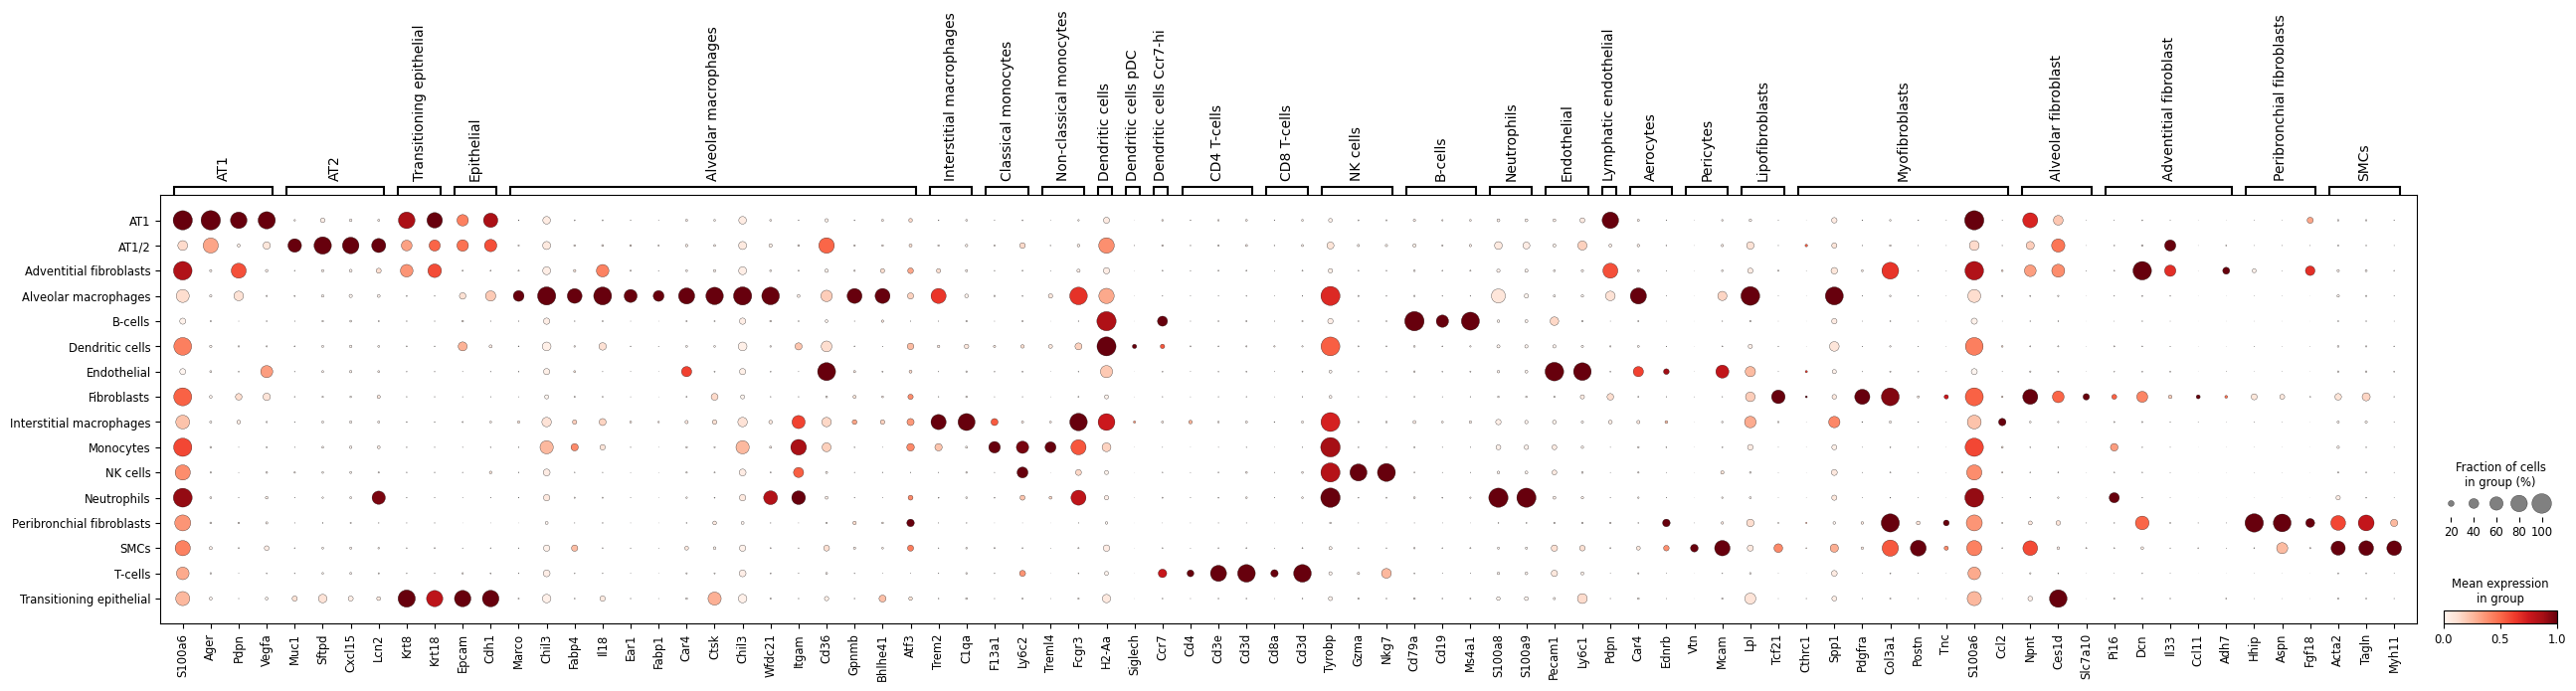

In [56]:
sc.pl.dotplot(adata_integrated, old_markers, groupby=["majority_anno"], standard_scale="var" )

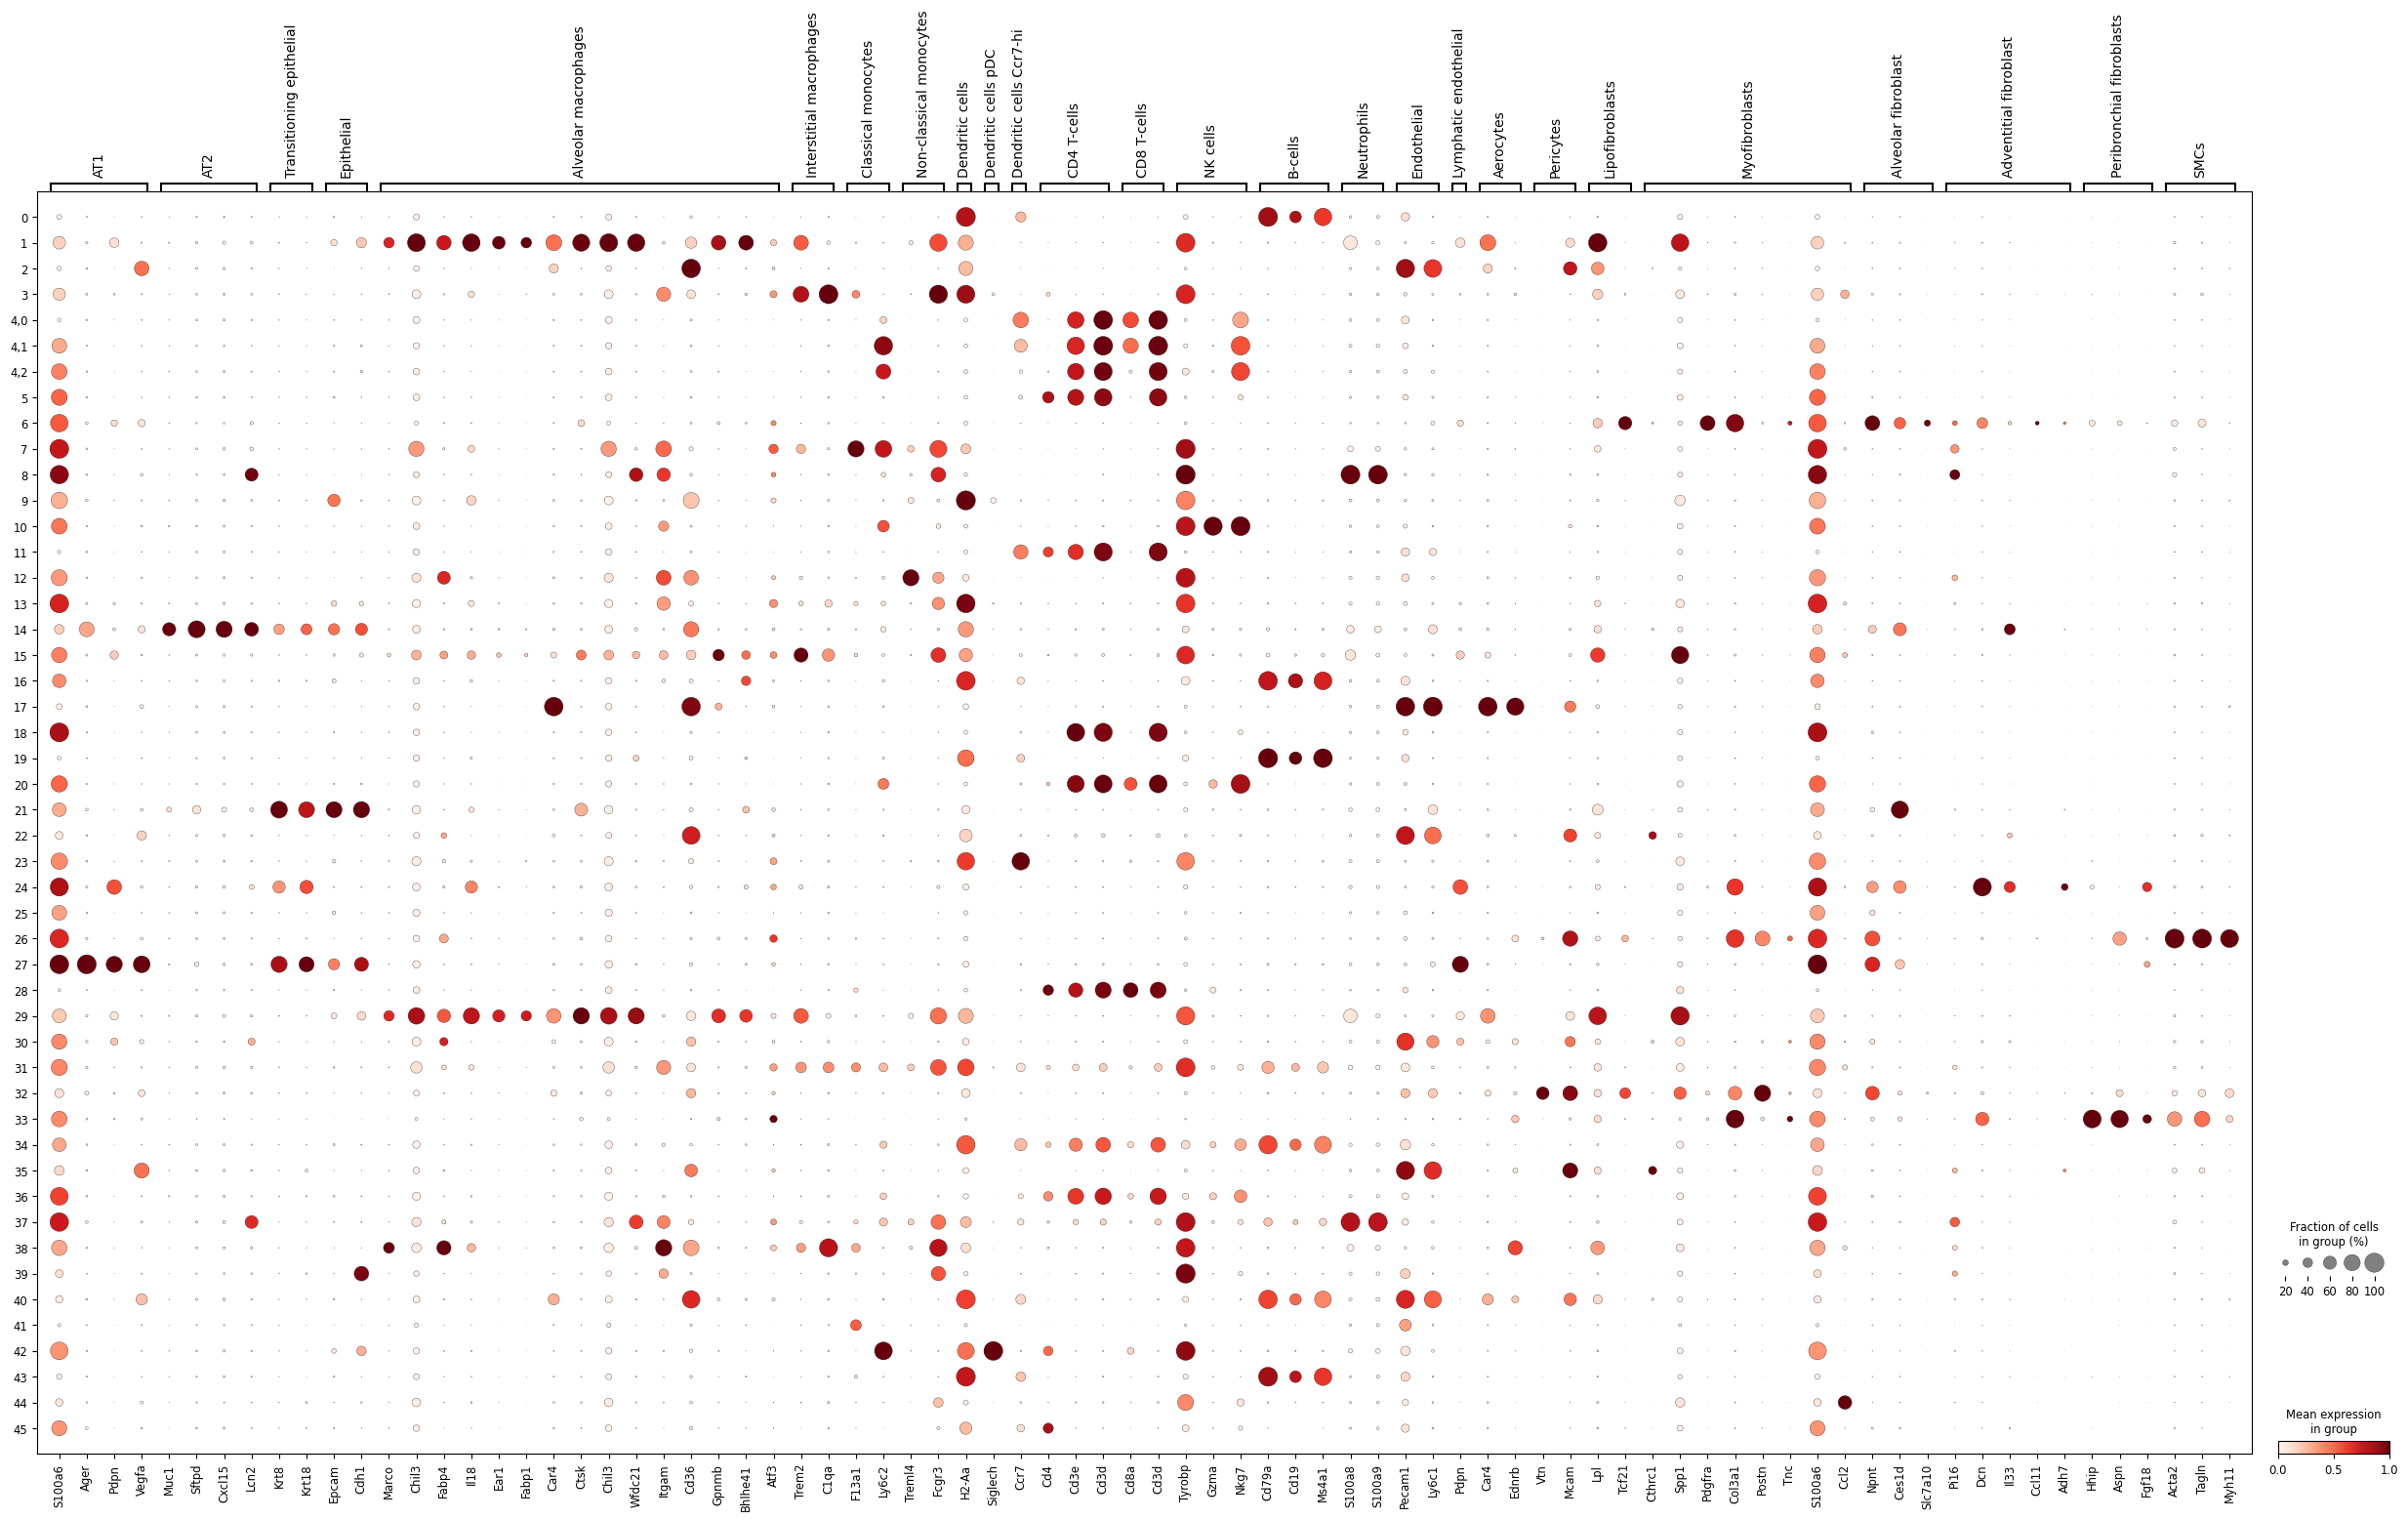

In [57]:
sc.pl.dotplot(adata_integrated, old_markers, groupby=["leiden_res1"], standard_scale="var" )

In [66]:
adata_integrated.var.index

Index(['1110017D15Rik', '1500015O10Rik', '1600010M07Rik', '1700001C02Rik',
       '1700007K13Rik', '1700016K19Rik', '1700024G13Rik', '1700026L06Rik',
       '1700088E04Rik', '1700094D03Rik',
       ...
       'Xpnpep2', 'Zap70', 'Zcchc18', 'Zcwpw1', 'Zfand4', 'Zfp318', 'Zfp503',
       'Zfp697', 'Zfp831', 'Zmynd15'],
      dtype='object', length=2007)

### new lung marker 

In [79]:
df = pd.read_csv('marker_genes.csv')

# Create an empty dictionary to store the mapping
cell_marker_dict = {}

# Iterate through the DataFrame and populate the dictionary
for index, row in df.iterrows():
    cell_name = row['Cell name']
    cell_marker = row['Cell marker']
    
    
    if cell_name not in cell_marker_dict:
        cell_marker_dict[cell_name] = []

    if cell_marker in adata_integrated.var.index:
        cell_marker_dict[cell_name].append(cell_marker)

#print(cell_marker_dict)
shortened_cell_marker_dict = {key: value[:6] for key, value in cell_marker_dict.items()}

In [60]:
cell_marker_dict.keys()

dict_keys(['Epithelial cell', 'Brush cell (Tuft cell)', 'Matrix fibroblast', 'Ciliated cell', 'Clara cell', 'Fibroblast', 'Endothelial cell', 'Pdgfrapha+ cell', 'Lipofibroblast', 'Myofibroblast', 'Smooth muscle cell', 'Lee et al.Cell.B', 'Axin2-Palpha+ cell', 'Lee et al.Cell.E', 'Axin2+ cell', 'Pericyte', 'Type I pneumocyte', 'Immune cell', 'Myeloid cell', 'Wnt2+ cell', 'Type II pneumocyte', 'Mesenchymal progenitor cell', 'Lgr5+ cell', 'Lgr6+ cell', 'Lee et al.Cell.C', 'Mesothelial cell', 'Lee et al.Cell.A', 'Lee et al.Cell.D'])

In [91]:
del shortened_cell_marker_dict['Lee et al.Cell.C']
del shortened_cell_marker_dict['Lee et al.Cell.A']
del shortened_cell_marker_dict['Lee et al.Cell.D']

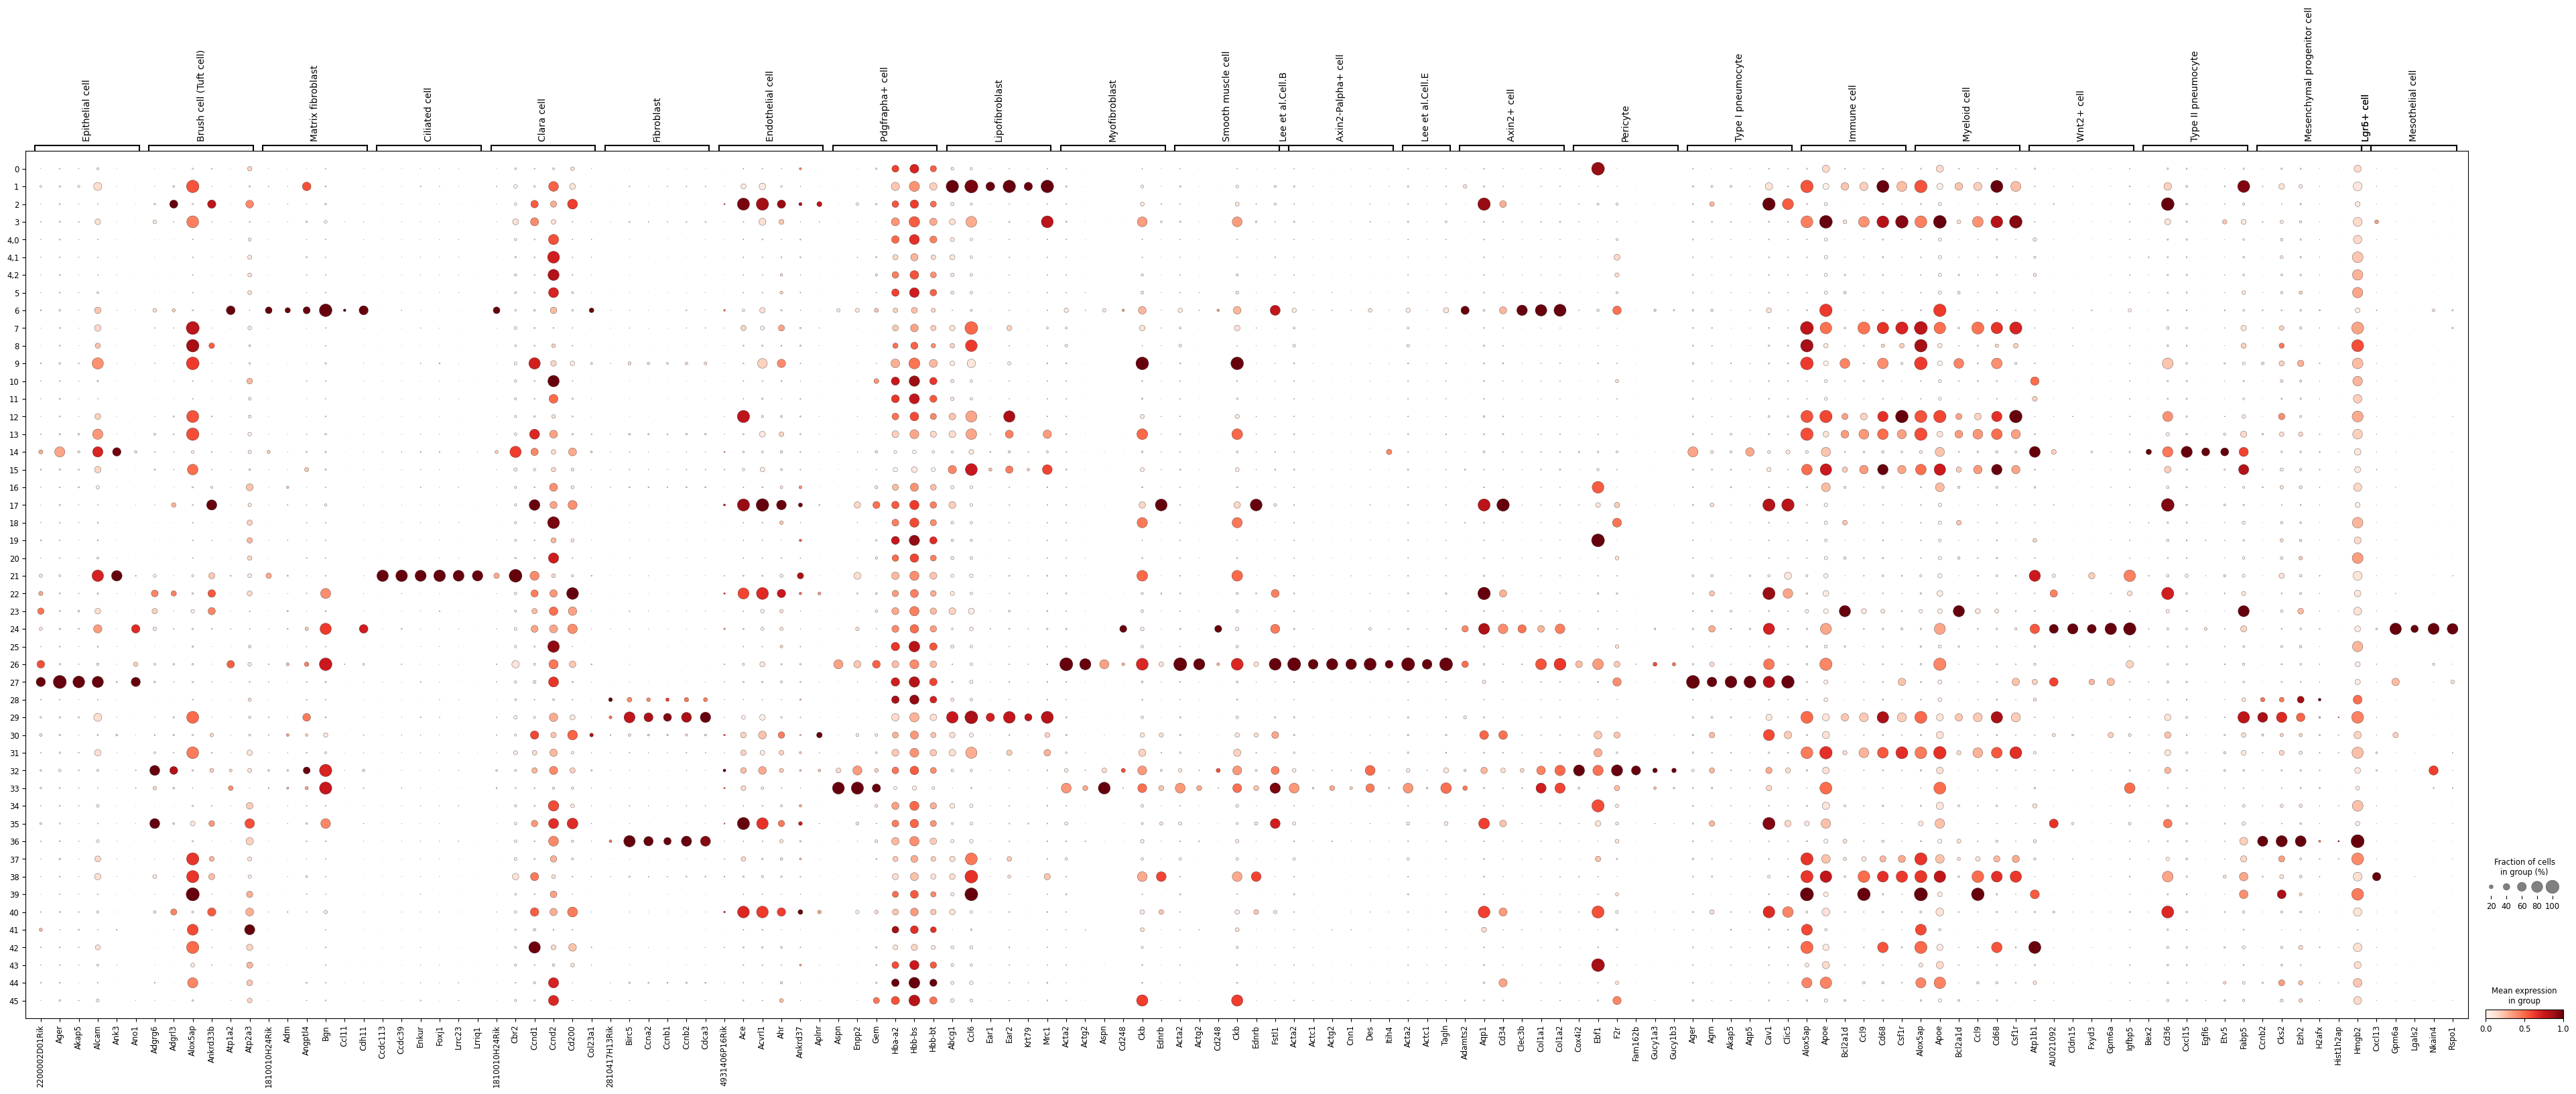

In [92]:
sc.pl.dotplot(adata_integrated, shortened_cell_marker_dict, groupby=["leiden_res1"], standard_scale="var" )

In [97]:
mapping_majority = dict(zip(adata_integrated.obs["leiden_res1"], adata_integrated.obs["majority_anno"]))

In [98]:
mapping_majority

{'6': 'Fibroblasts',
 '33': 'Peribronchial fibroblasts',
 '1': 'Alveolar macrophages',
 '9': 'Dendritic cells',
 '22': 'Endothelial',
 '24': 'Adventitial fibroblasts',
 '0': 'B-cells',
 '17': 'Endothelial',
 '16': 'B-cells',
 '2': 'Endothelial',
 '7': 'Monocytes',
 '42': 'Dendritic cells',
 '12': 'Monocytes',
 '10': 'NK cells',
 '25': 'T-cells',
 '11': 'T-cells',
 '14': 'AT1/2',
 '4,1': 'T-cells',
 '13': 'Dendritic cells',
 '15': 'Interstitial macrophages',
 '8': 'Neutrophils',
 '3': 'Interstitial macrophages',
 '31': 'Interstitial macrophages',
 '19': 'B-cells',
 '18': 'T-cells',
 '26': 'SMCs',
 '34': 'B-cells',
 '4,0': 'T-cells',
 '5': 'T-cells',
 '4,2': 'T-cells',
 '39': 'NK cells',
 '21': 'Transitioning epithelial',
 '32': 'SMCs',
 '29': 'Alveolar macrophages',
 '23': 'Dendritic cells',
 '20': 'T-cells',
 '35': 'Endothelial',
 '38': 'Interstitial macrophages',
 '37': 'Neutrophils',
 '45': 'T-cells',
 '40': 'Endothelial',
 '30': 'Endothelial',
 '44': 'NK cells',
 '36': 'T-cells',
 '

In [ ]:
final anno =
{'6': 'Matrix fibroblasts',
 '33': 'Peribronchial fibroblasts',
 '1': 'Alveolar macrophages',
 '9': 'Dendritic cells',#Myeloid  ab hier todo 
 '22': 'Endothelial',
 '24': 'Adventitial fibroblasts',
 '0': 'B-cells',
 '17': 'Endothelial',
 '16': 'B-cells',
 '2': 'Endothelial',
 '7': 'Monocytes',
 '42': 'Dendritic cells',
 '12': 'Monocytes',
 '10': 'NK cells',
 '25': 'T-cells',
 '11': 'T-cells',
 '14': 'AT1/2',
 '4,1': 'T-cells',
 '13': 'Dendritic cells',
 '15': 'Interstitial macrophages',
 '8': 'Neutrophils',
 '3': 'Interstitial macrophages',
 '31': 'Interstitial macrophages',
 '19': 'B-cells',
 '18': 'T-cells',
 '26': 'SMCs',
 '34': 'B-cells',
 '4,0': 'T-cells',
 '5': 'T-cells',
 '4,2': 'T-cells',
 '39': 'NK cells',
 '21': 'Transitioning epithelial',
 '32': 'SMCs',
 '29': 'Alveolar macrophages',
 '23': 'Dendritic cells',
 '20': 'T-cells',
 '35': 'Endothelial',
 '38': 'Interstitial macrophages',
 '37': 'Neutrophils',
 '45': 'T-cells',
 '40': 'Endothelial',
 '30': 'Endothelial',
 '44': 'NK cells',
 '36': 'T-cells',
 '27': 'AT1',
 '43': 'B-cells',
 '28': 'T-cells',
 '41': 'Endothelial'}

### new air way markers

In [87]:
df = pd.read_csv('airway_markers.csv')

# Create an empty dictionary to store the mapping
aw_cell_marker_dict = {}

# Iterate through the DataFrame and populate the dictionary
for index, row in df.iterrows():
    cell_name = row['Cell name']
    cell_marker = row['Cell marker']
    
    
    if cell_name not in cell_marker_dict:
        aw_cell_marker_dict[cell_name] = []

    #if cell_marker in adata_integrated.var.index:
        aw_cell_marker_dict[cell_name].append(cell_marker)


shortened_aw_cell_marker_dict = {key: value[:6] for key, value in aw_cell_marker_dict.items()}

In [75]:
aw_cell_marker_dict.keys()

dict_keys(['Naive CD4+ T cell', 'Naive CD8+ T cell', 'Activated tissue resident memory CD8+ T cell', 'Effector memory CD4+ T cell', 'Memory CD4+ T cell', 'Macrophage', 'Neutrophil', 'B cell', 'Plasma cell', 'Dendritic cell', 'Regulatory T(Treg) cell', 'Tissue resident memory CD4+ T cell', 'Activated effector memory CD4+ T cell', 'Activated tissue resident memory CD4+ T cell', 'T cell', 'Gamma delta(gamadelta) T cell', 'Tissue resident memory CD8+ T cell', 'Activated effector memory CD8+ T cell', 'Effector CD8+ T cell', 'Ionocyte', 'Club cell (Clara cell)', 'Goblet cell', 'Red blood cell (erythrocyte)', 'Platelet', 'Mast cell', 'Alveolar type II (ATII) cell', 'Natural killer cell', 'Alveolar cell Type 1'])

In [88]:
shortened_aw_cell_marker_dict

{'Airway cell': ['ACT'],
 'Macrophage': ['MAFB'],
 'Alveolar epithelial cell Type 2': ['pro-SPC']}

In [90]:
adata2 = sc.read("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/merged_data/integration/dataset~integration_merged_data/method~scvi/batch~batch,label~harmonized_anno,hyperparams~d453d7a675,lineage_key~None/adata.h5ad")

In [59]:
mapping = dict(zip(adata.obs.index, adata.obs["leiden_res1"]))


In [65]:
adata2.obs['leiden_res1'] = adata2.obs.index.map(mapping)

In [120]:
adata2.obs.index

Index(['AAACCTGAGGACATTA-1_xie', 'AAACCTGCAGTCGTGC-1_xie',
       'AAACCTGCATGAAGTA-1_xie', 'AAACCTGTCTCGCATC-1_xie',
       'AAACGGGTCCTAGAAC-1_xie', 'AAACGGGTCTAAGCCA-1_xie',
       'AAAGCAAAGGACTGGT-1_xie', 'AAAGCAAGTAGGCATG-1_xie',
       'AAAGCAAGTGTTGAGG-1_xie', 'AAAGCAATCCTCCTAG-1_xie',
       ...
       '343061_galapagos_rad', '343062_galapagos_rad', '343063_galapagos_rad',
       '343064_galapagos_rad', '343065_galapagos_rad', '343066_galapagos_rad',
       '343067_galapagos_rad', '343068_galapagos_rad', '343069_galapagos_rad',
       '343070_galapagos_rad'],
      dtype='object', length=535908)

In [119]:
adata.obs.index

Index(['AAACCTGAGGACATTA-1_xie', 'AAACCTGCAGTCGTGC-1_xie',
       'AAACCTGCATGAAGTA-1_xie', 'AAACCTGTCTCGCATC-1_xie',
       'AAACGGGTCCTAGAAC-1_xie', 'AAACGGGTCTAAGCCA-1_xie',
       'AAAGCAAAGGACTGGT-1_xie', 'AAAGCAAGTAGGCATG-1_xie',
       'AAAGCAAGTGTTGAGG-1_xie', 'AAAGCAATCCTCCTAG-1_xie',
       ...
       '343061_galapagos_rad', '343062_galapagos_rad', '343063_galapagos_rad',
       '343064_galapagos_rad', '343065_galapagos_rad', '343066_galapagos_rad',
       '343067_galapagos_rad', '343068_galapagos_rad', '343069_galapagos_rad',
       '343070_galapagos_rad'],
      dtype='object', length=535908)

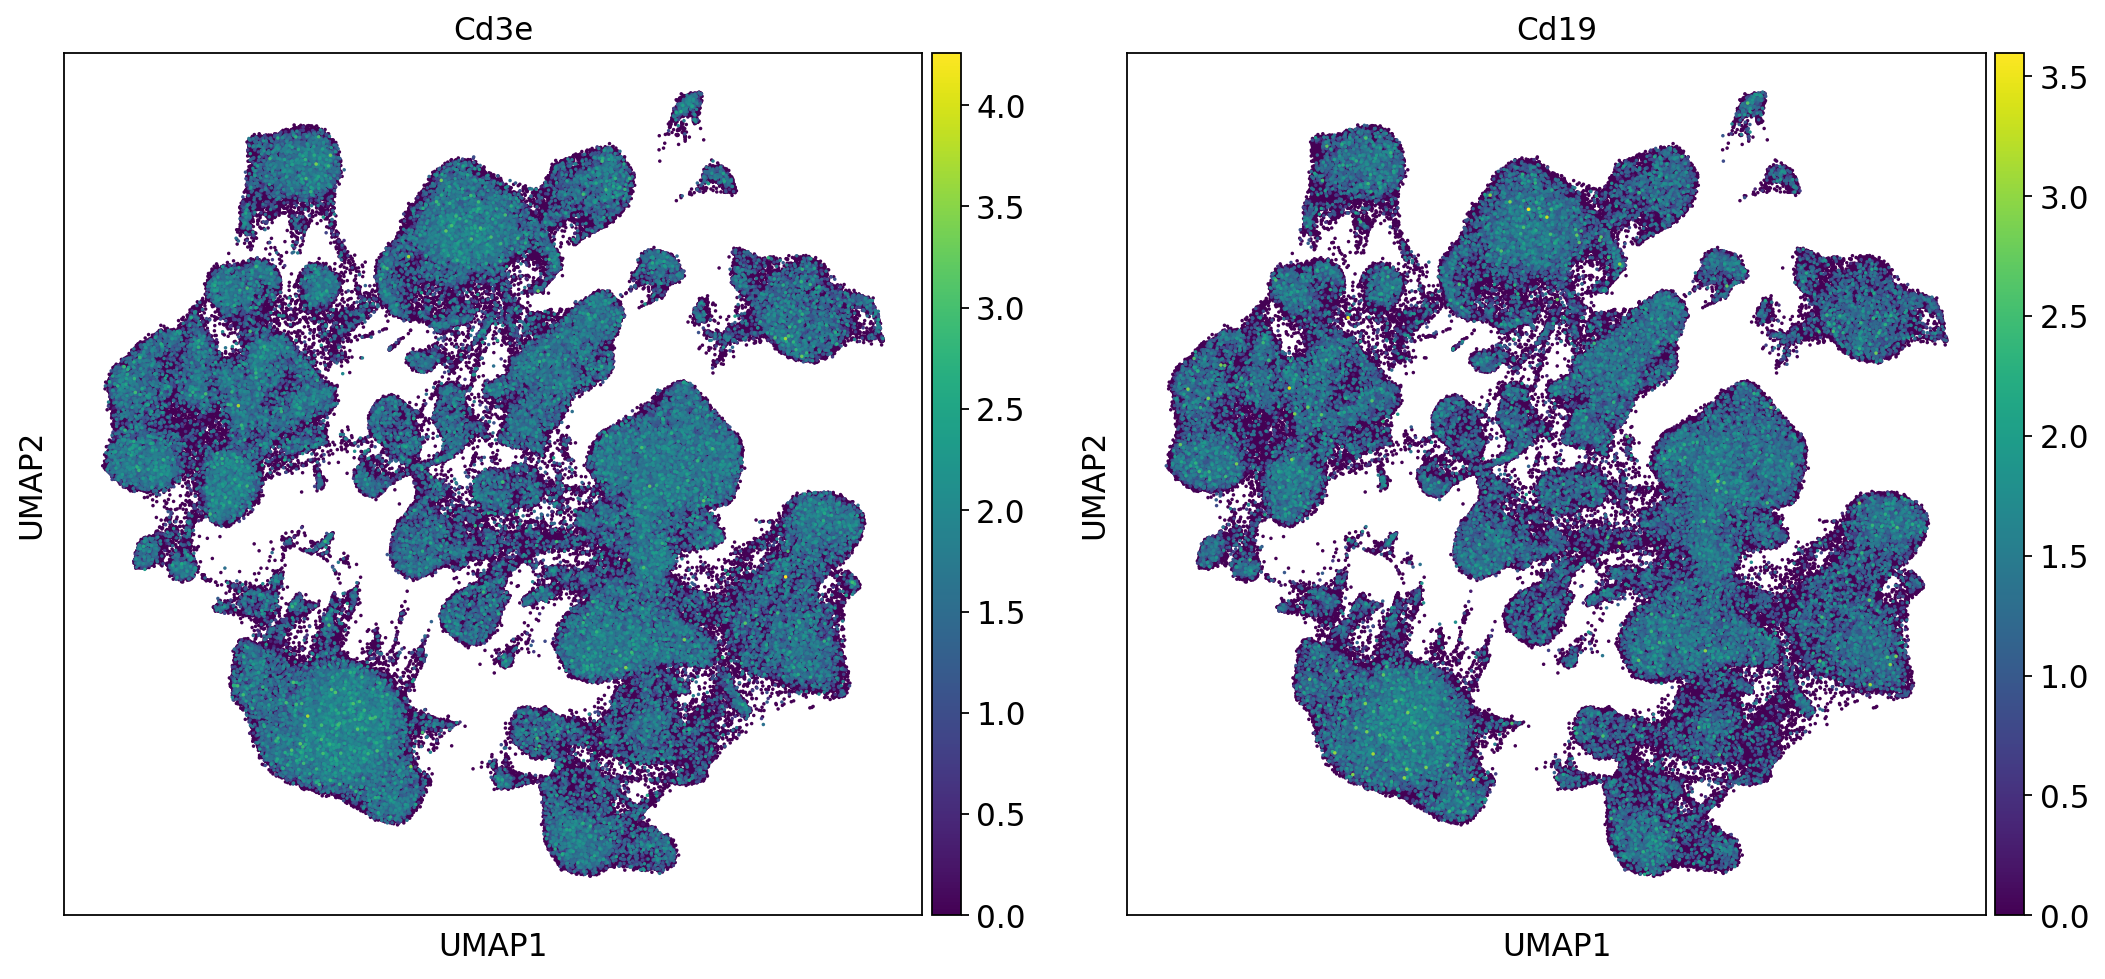

In [122]:
sc.pl.umap(
    adata,
    layer = "log1p_norm",
    color= ["Cd3e", "Cd19"], 
    legend_loc="on data", # palette=sc.pl.palettes.default_102,
    size = 10
)

<AxesSubplot: ylabel='Count'>

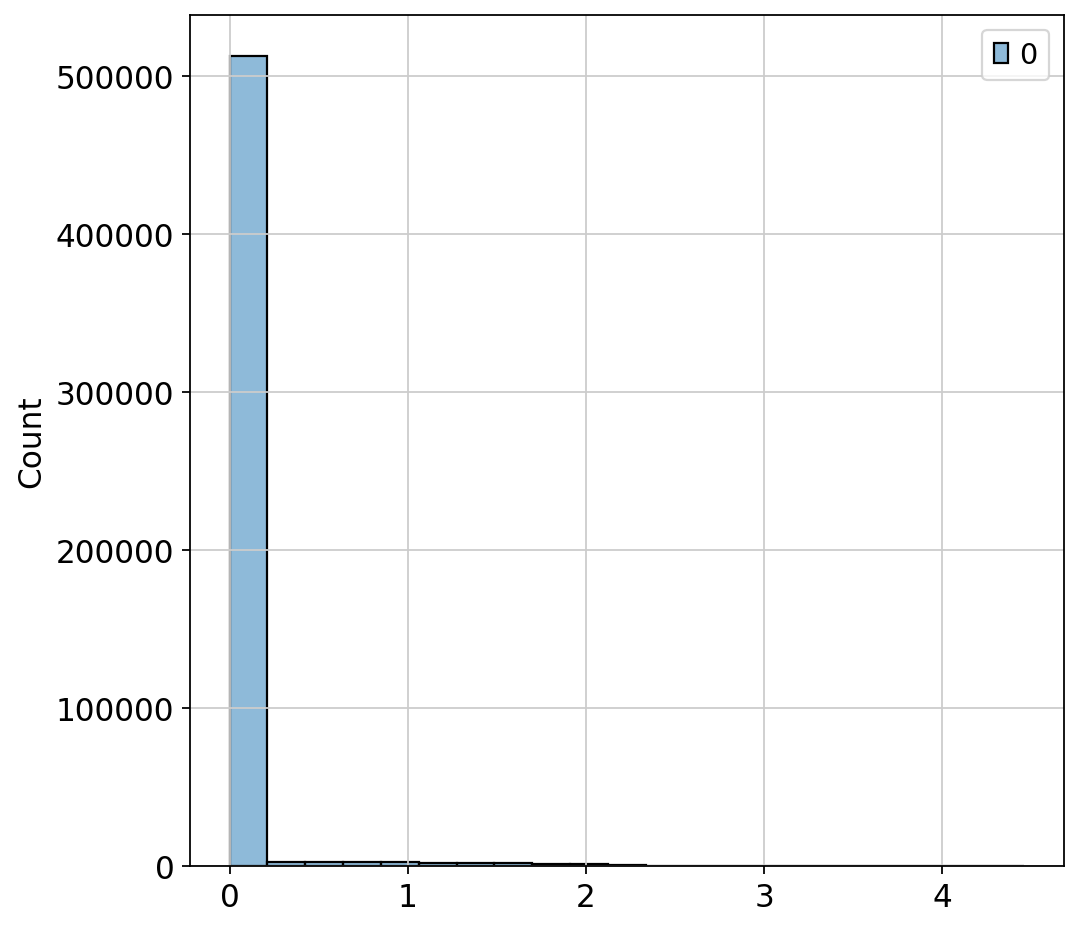

In [81]:
sns.histplot(adata[:,"Krt8"].layers["log1p_norm"].todense())

In [101]:
markers = {
  "AT1": ["S100a6", "Ager", "Pdpn", "Vegfa"],
  "AT2": ["Muc1", "Sftpd", "Cxcl15", "Lcn2"]}

In [96]:
adata.obs = adata.obs.reindex(adata2.obs.index)

In [116]:
map = adata[adata2.obs.index, :]

In [103]:
adata.obs 

author_annotation manual_celltype_annotation   
AAACCTGAGGACATTA-1_xie           Col13a1             Myofibroblasts  \
AAACCTGCAGTCGTGC-1_xie    Myofibroblasts  Peribronchial fibroblasts   
AAACCTGCATGAAGTA-1_xie   Lipofibroblasts       Alveolar macrophages   
AAACCTGTCTCGCATC-1_xie    Myofibroblasts  Peribronchial fibroblasts   
AAACGGGTCCTAGAAC-1_xie    Myofibroblasts  Peribronchial fibroblasts   
...                                  ...                        ...   
343066_galapagos_rad                 NaN       Alveolar macrophages   
343067_galapagos_rad                 NaN                        AT2   
343068_galapagos_rad                 NaN                    B-cells   
343069_galapagos_rad                 NaN                    B-cells   
343070_galapagos_rad                 NaN                    B-cells   

                                     batch  condition timepoint   
AAACCTGAGGACATTA-1_xie               1_xie  untreated       NaN  \
AAACCTGCAGTCGTGC-1_xie               1_xie  untreated       NaN   
AAACCTGCATGAAGTA-1_xie               1_xie  untreated       NaN   
AAACCTGTCTCGCATC-1_xie               1_xie  untreated       NaN   
AAACGGGTCCTAGAAC-1_xie               1_xie  untreated       NaN   
...                                    ...        ...       ...   
343066_galapagos_rad    74.0_galapagos_rad  radiation       NaN   
343067_galapagos_rad    74.0_galapagos_rad  radiation       NaN   
343068_galapagos_rad    74.0_galapagos_rad  radiation       NaN   
343069_galapagos_rad    74.0_galapagos_rad  radiation       NaN   
343070_galapagos_rad    74.0_galapagos_rad  radiation       NaN   

                              dataset fibrotic/control coarse_harmonized_anno   
AAACCTGAGGACATTA-1_xie            xie          control         Myofibroblasts  \
AAACCTGCAGTCGTGC-1_xie            xie          control            Fibroblasts   
AAACCTGCATGAAGTA-1_xie            xie          control   Alveolar macrophages   
AAACCTGTCTCGCATC-1_xie            xie          control            Fibroblasts   
AAACGGGTCCTAGAAC-1_xie            xie          control            Fibroblasts   
...                               ...              ...                    ...   
343066_galapagos_rad    galapagos_rad         fibrotic                    NaN   
343067_galapagos_rad    galapagos_rad         fibrotic                    NaN   
343068_galapagos_rad    galapagos_rad         fibrotic                    NaN   
343069_galapagos_rad    galapagos_rad         fibrotic                    NaN   
343070_galapagos_rad    galapagos_rad         fibrotic                    NaN   

                       Phase SAMP_stage  ... n_genes  doublet_score   
AAACCTGAGGACATTA-1_xie   NaN        NaN  ...    1220       0.042383  \
AAACCTGCAGTCGTGC-1_xie   NaN        NaN  ...    1184       0.016535   
AAACCTGCATGAAGTA-1_xie   NaN        NaN  ...     884       0.023217   
AAACCTGTCTCGCATC-1_xie   NaN        NaN  ...     679       0.021722   
AAACGGGTCCTAGAAC-1_xie   NaN        NaN  ...     595       0.016535   
...                      ...        ...  ...     ...            ...   
343066_galapagos_rad       S    19weeks  ...    5055       0.047278   
343067_galapagos_rad      G1    19weeks  ...    4969       0.131098   
343068_galapagos_rad     G2M    19weeks  ...     812       0.014366   
343069_galapagos_rad     G2M    19weeks  ...     562       0.019910   
343070_galapagos_rad       S    19weeks  ...     698       0.019137   

                        predicted_doublet                  cell_type   
AAACCTGAGGACATTA-1_xie              False                Fibroblasts  \
AAACCTGCAGTCGTGC-1_xie              False  Peribronchial fibroblasts   
AAACCTGCATGAAGTA-1_xie              False       Alveolar macrophages   
AAACCTGTCTCGCATC-1_xie              False  Peribronchial fibroblasts   
AAACGGGTCCTAGAAC-1_xie              False  Peribronchial fibroblasts   
...                                   ...                        ...   
343066_galapagos_rad               

In [104]:
adata2.obs

author_annotation manual_celltype_annotation   
AAACCTGAGGACATTA-1_xie           Col13a1             Myofibroblasts  \
AAACCTGCAGTCGTGC-1_xie    Myofibroblasts  Peribronchial fibroblasts   
AAACCTGCATGAAGTA-1_xie   Lipofibroblasts       Alveolar macrophages   
AAACCTGTCTCGCATC-1_xie    Myofibroblasts  Peribronchial fibroblasts   
AAACGGGTCCTAGAAC-1_xie    Myofibroblasts  Peribronchial fibroblasts   
...                                  ...                        ...   
343066_galapagos_rad                 NaN       Alveolar macrophages   
343067_galapagos_rad                 NaN                        AT2   
343068_galapagos_rad                 NaN                    B-cells   
343069_galapagos_rad                 NaN                    B-cells   
343070_galapagos_rad                 NaN                    B-cells   

                                     batch  condition timepoint   
AAACCTGAGGACATTA-1_xie               1_xie  untreated       NaN  \
AAACCTGCAGTCGTGC-1_xie               1_xie  untreated       NaN   
AAACCTGCATGAAGTA-1_xie               1_xie  untreated       NaN   
AAACCTGTCTCGCATC-1_xie               1_xie  untreated       NaN   
AAACGGGTCCTAGAAC-1_xie               1_xie  untreated       NaN   
...                                    ...        ...       ...   
343066_galapagos_rad    74.0_galapagos_rad  radiation       NaN   
343067_galapagos_rad    74.0_galapagos_rad  radiation       NaN   
343068_galapagos_rad    74.0_galapagos_rad  radiation       NaN   
343069_galapagos_rad    74.0_galapagos_rad  radiation       NaN   
343070_galapagos_rad    74.0_galapagos_rad  radiation       NaN   

                              dataset fibrotic/control coarse_harmonized_anno   
AAACCTGAGGACATTA-1_xie            xie          control         Myofibroblasts  \
AAACCTGCAGTCGTGC-1_xie            xie          control            Fibroblasts   
AAACCTGCATGAAGTA-1_xie            xie          control   Alveolar macrophages   
AAACCTGTCTCGCATC-1_xie            xie          control            Fibroblasts   
AAACGGGTCCTAGAAC-1_xie            xie          control            Fibroblasts   
...                               ...              ...                    ...   
343066_galapagos_rad    galapagos_rad         fibrotic                    NaN   
343067_galapagos_rad    galapagos_rad         fibrotic                    NaN   
343068_galapagos_rad    galapagos_rad         fibrotic                    NaN   
343069_galapagos_rad    galapagos_rad         fibrotic                    NaN   
343070_galapagos_rad    galapagos_rad         fibrotic                    NaN   

                       Phase SAMP_stage  ... total_counts  log1p_total_counts   
AAACCTGAGGACATTA-1_xie   NaN        NaN  ...       2549.0            7.843849  \
AAACCTGCAGTCGTGC-1_xie   NaN        NaN  ...       2271.0            7.728416   
AAACCTGCATGAAGTA-1_xie   NaN        NaN  ...       1642.0            7.404279   
AAACCTGTCTCGCATC-1_xie   NaN        NaN  ...       1196.0            7.087574   
AAACGGGTCCTAGAAC-1_xie   NaN        NaN  ...        944.0            6.851185   
...                      ...        ...  ...          ...                 ...   
343066_galapagos_rad       S    19weeks  ...      20895.0            9.947313   
343067_galapagos_rad      G1    19weeks  ...      25350.0           10.140573   
343068_galapagos_rad     G2M    19weeks  ...       1846.0            7.521318   
343069_galapagos_rad     G2M    19weeks  ...       1487.0            7.305188   
343070_galapagos_rad       S    19weeks  ...       1504.0            7.316548   

                        pct_counts_in_top_20_genes  total_counts_mt   
AAACCTGAGGACATTA-1_xie                   26.794821            194.0  \
AAACCTGCAGTCGTGC-1_xie                   23.029502             48.0   
AAACCTGCATGAAGTA-1_xie                   19.975639             22.0   
AAACCTGTCTCGCATC-1_xie                   28.428094             15.0   
AAACGGGTCCTAGAAC-1_xie                   27.648305             2

In [92]:
adata2

AnnData object with n_obs × n_vars = 535908 × 2007
    obs: 'author_annotation', 'manual_celltype_annotation', 'batch', 'condition', 'timepoint', 'dataset', 'fibrotic/control', 'coarse_harmonized_anno', 'Phase', 'SAMP_stage', 'SC_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_group', 'harmonized_anno', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset', 'dataset_colors', 'hvg', 'integration', 'manual_celltype_annotation_colors', 'methods', 'neighbors', 'pca', 'umap'
    obsm: 'X_emb', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm'
    obsp: 

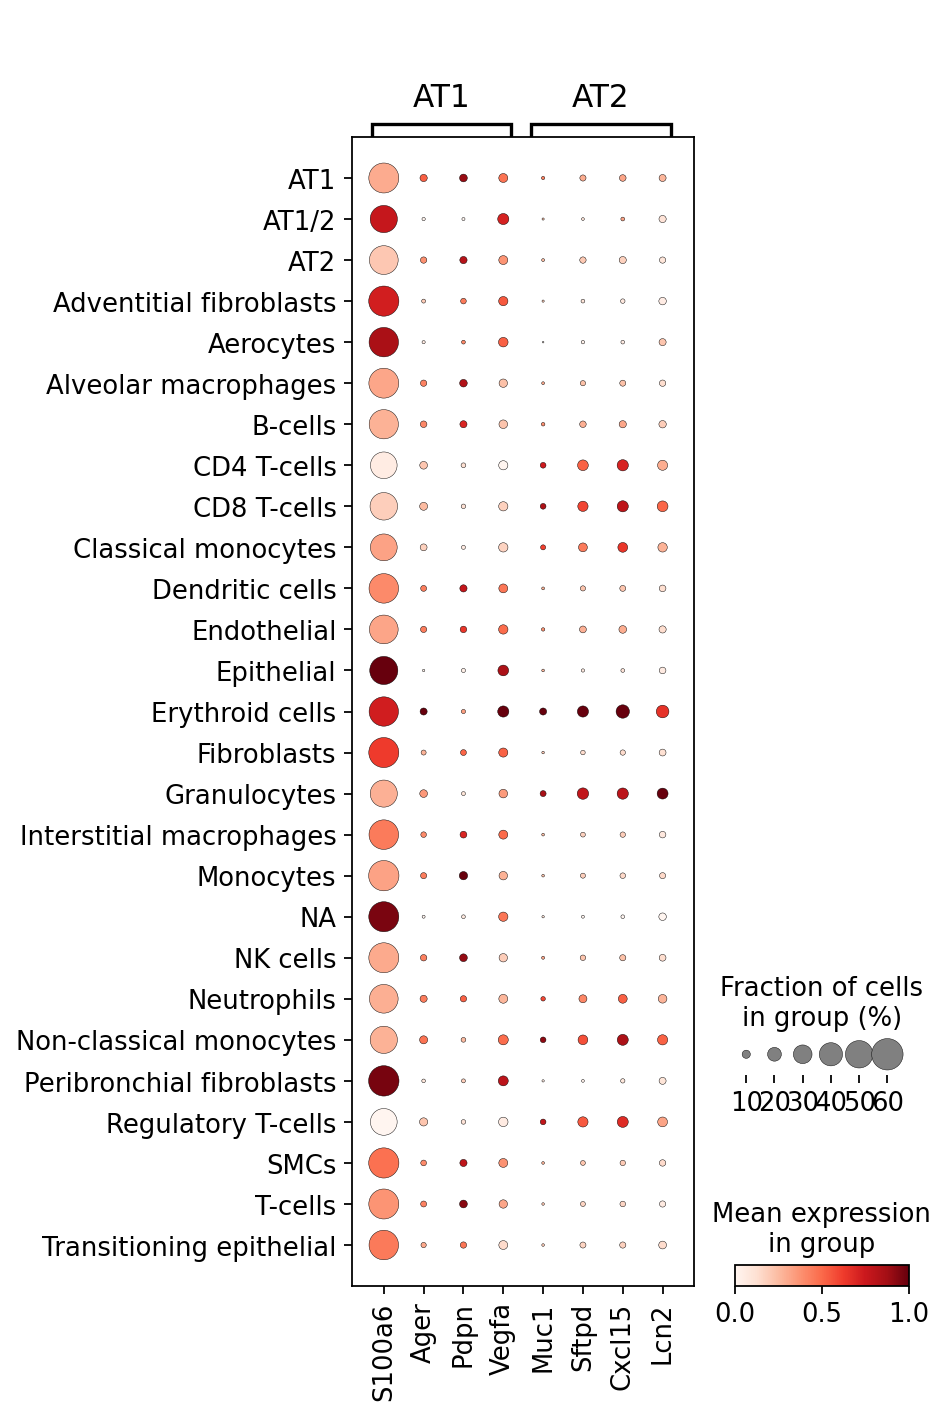